## humidity and org - one model

In [ ]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

: 

In [3]:
def to_monthly(da):
    year = da.time.dt.year
    month = da.time.dt.month

    # assign new coords
    da = da.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return da.set_index(time=("year", "month")).unstack("time")

In [4]:
def plot_snapshot(scene, cmap, title, vmin=None, vmax=None):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = scene.lat
    lon = scene.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(20, 10))
    scene.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(title)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

In [ ]:
def plot_sceneThreshold(scene1, scene2, cmap1, cmap2, title):
    fig= plt.figure(figsize=(18.8,10))
    lat = scene1.lat
    lon = scene1.lon
    lonm,latm = np.meshgrid(lon,lat)
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())

    pcm= ax.pcolormesh(lonm,latm, scene1, transform=ccrs.PlateCarree(),zorder=0, cmap=cmap1)
    ax.pcolormesh(lonm,latm, scene2, transform=ccrs.PlateCarree(), cmap=cmap2)

    ax.set_title(title)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

    ax.set_yticks([-20, 0, 20])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])

    plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'pr [mm/day]')

In [34]:
def plot_timeseries(y, variable_name, series_type):
    plt.figure(figsize=(25,5))
    plt.plot(y)
    plt.axhline(y=y.mean(dim='time'), color='k')
    plt.title(variable_name + ', '+ series_type + ', ' + model + ', ' + experiment)
    plt.ylabel(variable_name + ' ['+y.units+']')
    plt.xlabel(series_type)

In [38]:
def plot_scatter(x,y,scatter_type):
    f, ax = plt.subplots(figsize = (12.5,8))
    res= stats.pearsonr(x,y)

    plt.scatter(x,y,facecolors='none', edgecolor='k')
    plt.ylabel('F_pr10 [Nb]')
    plt.xlabel(org_option + ' ['+ x.units +']')
    title = 'F_pr10 and ' + org_option + ', ' + scatter_type + ', ' + model + ', ' + experiment

    if res[1]<=0.05:
        plt.title(title + ', R$^2$ = '+ str(round(res[0]**2,3)) + ', r=' + str(round(res[0],3)))
    else:
        plt.title(title + ', not statistically significant')

In [ ]:
def plot_bins(x,y, bin_type):
    plt.figure(figsize=(15,5))

    bin_width = (org.max() - org.min())/100
    bin_end = org.max()
    bins = np.arange(0, bin_end+bin_width, bin_width)

    areaFrac_bins = []
    for i in np.arange(0,len(bins)-1):
        areaFrac_bins = np.append(areaFrac_bins, pw.weighted(aWeights).mean(dim=('lat','lon'),keep_attrs=True).where((org>=bins[i]) & (org<=bins[i+1])).mean())
    plt.plot(areaFrac_bins)

    plt.title('pw and ' + org_option + ', ' + bin_type + ', ' + model + ', ' + experiment)
    plt.ylabel('pw [mm/day]')
    plt.xlabel(org_option + ' ['+ x.units +']')

In [14]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',       # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments = [
    'historical',
    #'rcp85'
    ]
experiment = experiments[0]       


org_options = [
    'rome',
    # 'rome_n'
    ]
org_option = org_options[0]

folder = home + '/Documents/data/cmip5/ds'
fileName = model + '_precip_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
precip = ds.precip*60*60*24
precip.attrs['units']= 'mm/day'

hus = xr.open_dataset(home + '/Documents/data/cmip5/' + 'ds' + '/' + model + '_hus_' + experiment + '.nc').hus
aWeights = np.cos(np.deg2rad(hus.lat))

pw = xr.DataArray(
    data=-scipy.integrate.simpson(hus.fillna(0), hus.plev.data, axis=1, even='last'),
    dims=['time','lat', 'lon'],
    coords={'time': hus.time.data, 'lat': hus.lat.data, 'lon': hus.lon.data},
    attrs={'units':'mm/day',
            'Description': 'precipitable water'}
    )

if org_option == 'rome' or org_option == 'rome_n':
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    org = ds[org_option]

In [ ]:
# divide by 10

In [56]:
hus.plev

<xarray.DataArray 'plev' (plev: 8)>
array([100000.,  85000.,  70000.,  50000.,  25000.,  10000.,   5000.,   1000.])
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03

### example of percipitable water and convection

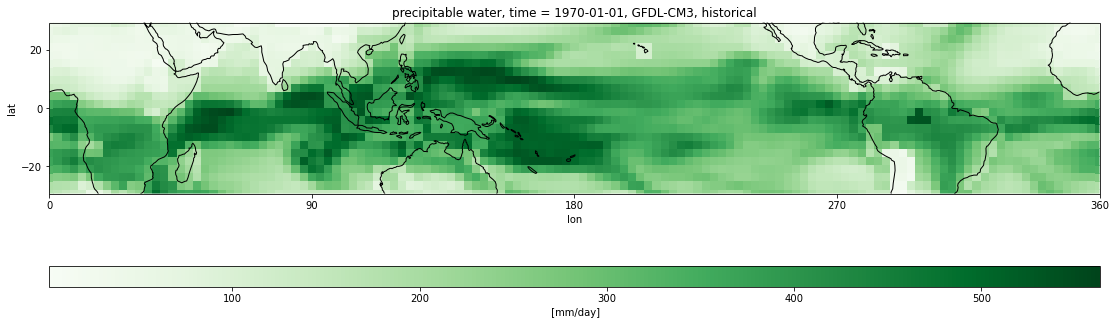

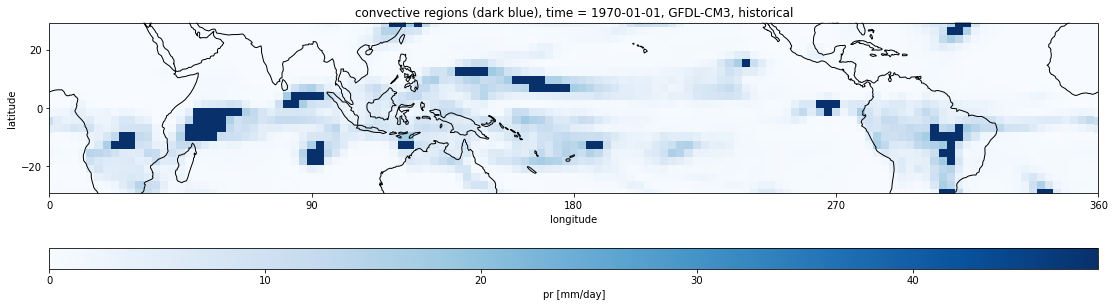

In [32]:
day = 0
scene = pw.isel(time=day)
cmap = 'Greens'
title = 'precipitable water, ' + 'time = ' + str(pw.isel(time=day).coords['time'].values)[:10] + ', ' + model + ', ' + experiment

plot_snapshot(scene, cmap, title)


scene1 = precip.isel(time=day)
threshold = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc').pr97.mean(dim='time').values
L = skm.label(scene1.where(scene1>=threshold,0)>0, background=np.nan,connectivity=2)
L = (L>0)*1
labelMatrix = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': scene1.lat.data, 'lon': scene1.lon.data}
    )
scene2 = labelMatrix.where(labelMatrix>0)
cmap1= 'Blues'
cmap2 = 'Blues_r'
title = 'convective regions (dark blue), ' + 'time = ' + str(precip.isel(time=day).coords['time'].values)[:10] + ', ' + model + ', ' + experiment

plot_sceneThreshold(scene1, scene2, cmap1, cmap2, title)

### individual timeseries

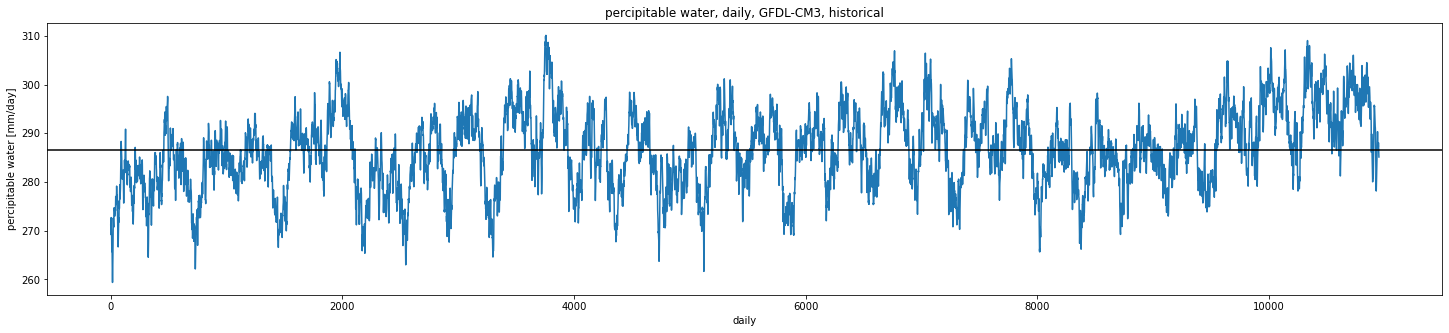

In [36]:
y = pw.weighted(aWeights).mean(dim=('lat','lon'),keep_attrs=True)
variable_name = 'percipitable water'
series_type = 'daily'


plot_timeseries(y, variable_name, series_type)

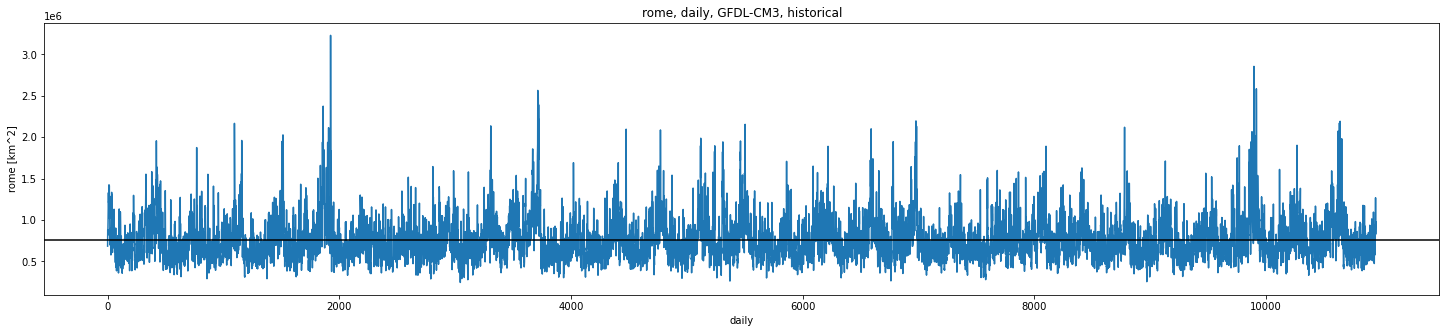

In [37]:
y = org
variable_name = org_option
series_type = 'daily'

plot_timeseries(y, variable_name, series_type)

## Correlations

### monthly

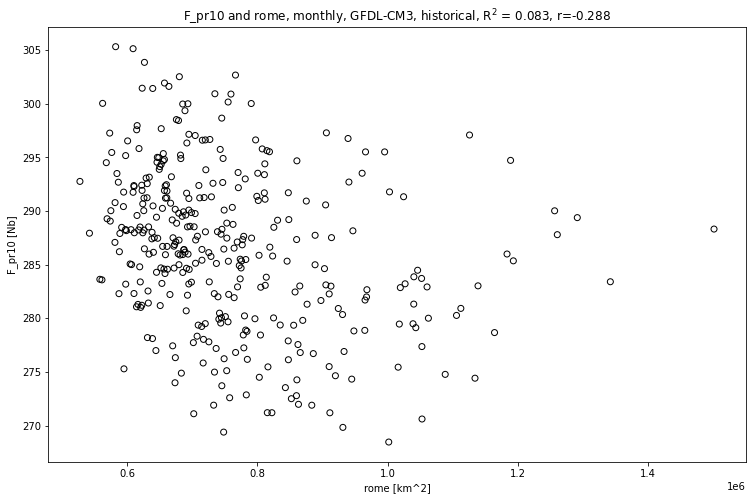

In [50]:
x = org.resample(time='M').mean(dim='time', keep_attrs=True)
y = pw.weighted(aWeights).mean(dim=('lat','lon'),keep_attrs=True).resample(time='M').mean(dim='time', keep_attrs=True)
scatter_type = 'monthly'

plot_scatter(x,y,scatter_type)

### daily

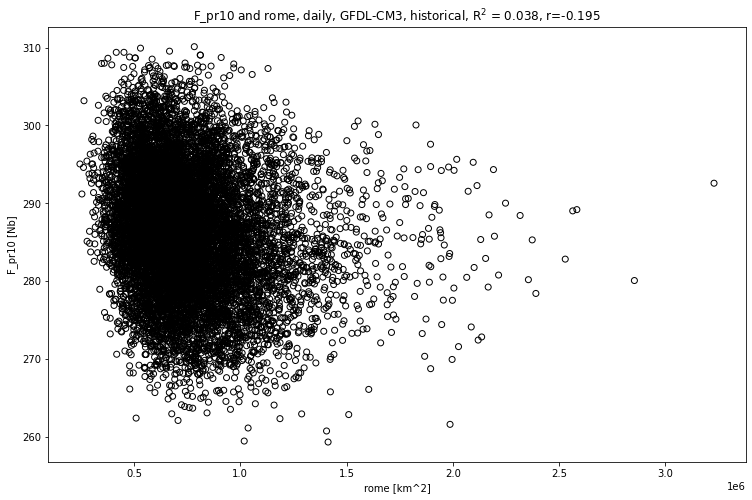

In [52]:
x = org
y = pw.weighted(aWeights).mean(dim=('lat','lon'),keep_attrs=True)
scatter_type = 'daily'

plot_scatter(x,y,scatter_type)

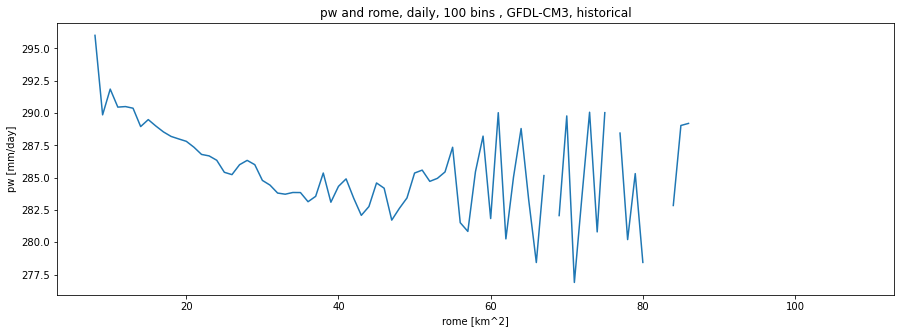

In [55]:
x = org
y = pw.weighted(aWeights).mean(dim=('lat','lon'),keep_attrs=True)
bin_type = 'daily, 100 bins '

plot_bins(x,y, bin_type)

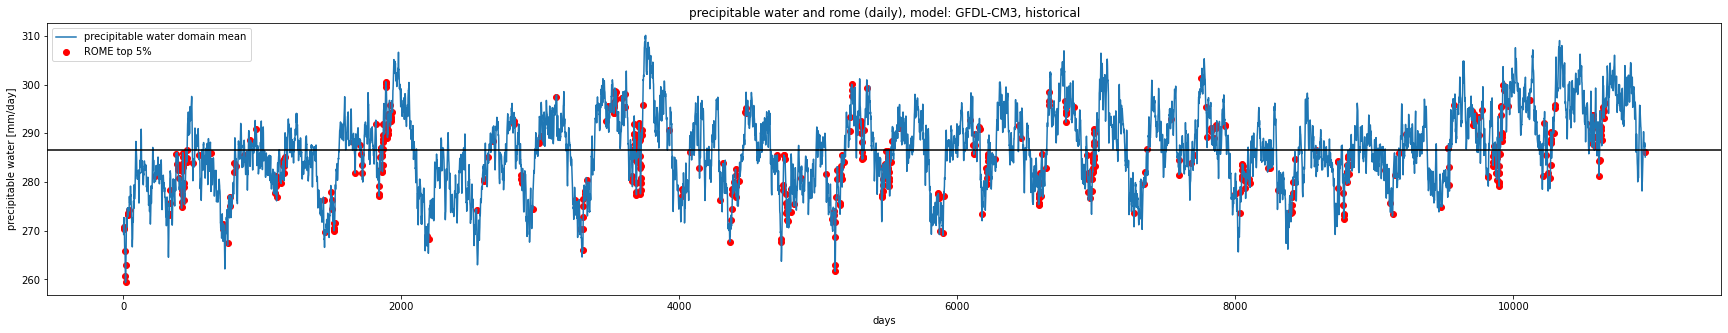

In [17]:
f, ax = plt.subplots(figsize = (30,5))

y = pw.weighted(aWeights).mean(dim=('lat','lon')).data
x= np.arange(0,len(y),1)
rome_prctile = np.percentile(rome[rome_option],95)
x2= np.argwhere(rome[rome_option].data>=rome_prctile)

ax.plot(x,y, label='precipitable water domain mean')
ax.scatter(x2,y[x2],label='ROME top 5%', color='r')
ax.axhline(y=np.mean(y), color='k')
ax.set_title('precipitable water and ' + rome_option + ' (daily), model: ' + model + ', ' + experiment)
ax.set_xlabel('days')
ax.set_ylabel('precipitable water [mm/day]')
ax.legend()

### as anomaly from the monthly mean

In [18]:
# pw_sMean = pw.weighted(aWeights).mean(dim=('lat','lon'))
# pw_sMean

# import xrft
# pw_fourier = xrft.dft(pw_sMean, dim='time', shift=False)
# power_spectrum = (pw_fourier*pw_fourier.conj()).real
# plt.plot(frequency[1:], power_spectrum[1:])
# plt.xlabel('Frequency [cycles per day]')
# plt.ylabel('Power')
# np.sort(power_spectrum)[-5:]

# data = pw_sMean.values
# fft = np.fft.fft(data)
# psd = np.abs(fft)**2

# plt.plot(psd)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectrum')

# def detrend_dim(da, dim, deg=1):
#     # detrend along a single dimension
#     p = da.polyfit(dim=dim, deg=deg)
#     fit = xr.polyval(dim, p.polyfit_coefficients)
#     return da - fit

# def detrend(da, dims, deg=1):
#     # detrend along multiple dimensions
#     # only valid for linear detrending (deg=1)
#     da_detrended = da
#     for dim in dims:
#         da_detrended = detrend_dim(da_detrended, dim, deg=deg)
#     return da_detrended

### in ascent and descent regions

In [45]:
folder = '/Users/cbla0002/Documents/data/cmip5/ds'
fileName = model + '_wap500_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
wap500 = ds.wap500

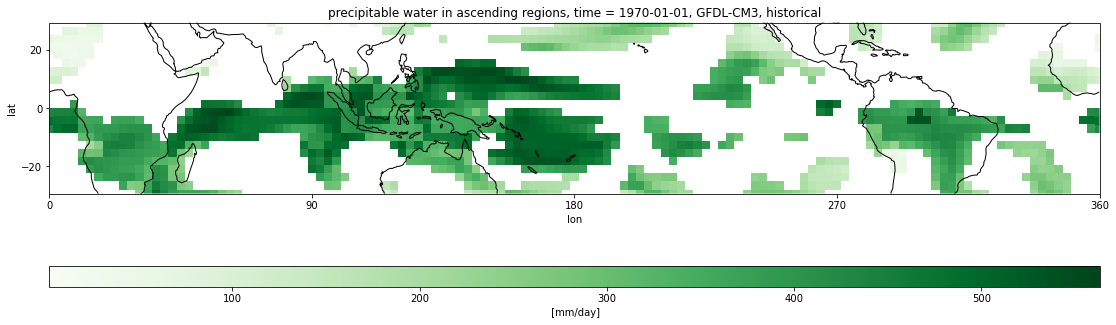

In [49]:
day = 0
scene = pw.isel(time=day).where(wap500.isel(time=day)<0, np.nan)
cmap = 'Greens'
title = 'precipitable water in ascending regions, ' + 'time = ' + str(pw.isel(time=day).coords['time'].values)[:10] + ', ' + model + ', ' + experiment

plot_snapshot(scene, cmap, title)

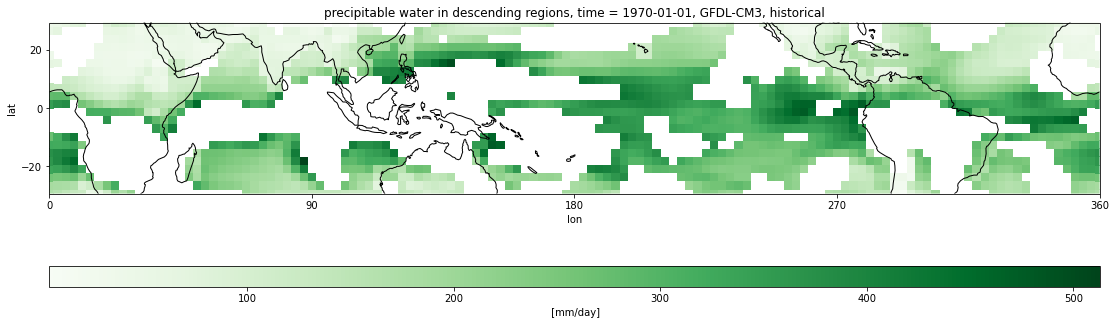

In [47]:
day = 0
scene = pw.isel(time=day).where(wap500.isel(time=day)>0, np.nan)
cmap = 'Greens'
title = 'precipitable water in descending regions, ' + 'time = ' + str(pw.isel(time=day).coords['time'].values)[:10] + ', ' + model + ', ' + experiment

plot_snapshot(scene, cmap, title)